In [1]:
import sys
sys.path.append('../')

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.pyplot import imshow
from tqdm import tqdm
import torch
from torch.nn import Module
# from torchsummary import summary

from collections import namedtuple, defaultdict
from pathlib import Path
import time

%matplotlib inline
rcParams['figure.figsize'] = (10, 15)

In [3]:
from src.constructor.config_structure import TrainConfigParams
from src.registry import TASKS
from src.constructor.data import create_dataset
from src.constructor.trainer import download_s3_artifact
from train import load_config

In [4]:
def load_hparams(config_path):
    hparams = load_config(config_path)
    hparams = TrainConfigParams(**hparams)
    
    return hparams

In [5]:
config_path = '../examples/configs/yolox.yml'
config = load_hparams(config_path)

In [6]:
# Prevent XBM from loading
config.task.params['xbm_params'] = None

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
checkpoint = torch.load('/home/lolik/torchok/99-6999.ckpt', map_location=device)
model = TASKS.get(config.task.name)(config)
model = model.to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval();
model = model.to(device).half()

load state dict = <All keys matched successfully>


In [9]:
data_params = config.data
dataset_name = data_params.train_params.name
common_params = data_params.common_params
# other_params = data_params.train_params
other_params = data_params.valid_params
# other_params = data_params.test_params

dataset = create_dataset(dataset_name, common_params, other_params)
dataset[100]

{'input': tensor([[[-2.1172, -2.1172, -2.1172,  ..., -1.8271, -1.8096, -1.7412],
          [-2.1172, -2.1172, -2.1172,  ..., -1.9297, -1.9121, -1.8779],
          [-2.1172, -2.1172, -2.1016,  ..., -1.9639, -1.9463, -1.8955],
          ...,
          [-1.0732, -1.4844, -0.6279,  ..., -1.0566, -1.2617, -1.2617],
          [-1.0566, -0.8677, -1.0049,  ..., -1.1074, -1.1934, -1.1934],
          [-0.4055, -1.0049, -1.4844,  ..., -0.7651, -1.0908, -1.1934]],
 
         [[-0.5127, -0.4951, -0.4951,  ..., -0.5649, -0.5649, -0.6177],
          [-0.5127, -0.4951, -0.4602,  ..., -0.5127, -0.4775, -0.5825],
          [-0.4951, -0.4775, -0.4426,  ..., -0.5127, -0.4426, -0.4775],
          ...,
          [-0.7402, -0.3201,  0.3276,  ...,  0.7129,  0.5376,  0.2227],
          [-0.4775,  0.4329, -0.1799,  ...,  0.7305,  0.3452,  0.1351],
          [-0.0224, -0.0399, -1.1250,  ...,  1.0635,  0.2227,  0.1002]],
 
         [[ 1.0537,  1.0537,  1.0537,  ..., -0.1312, -0.1312,  0.0779],
          [ 1.0537,

[{'x_min': 652, 'x_max': 691, 'y_min': 150, 'y_max': 192, 'label': 1}]


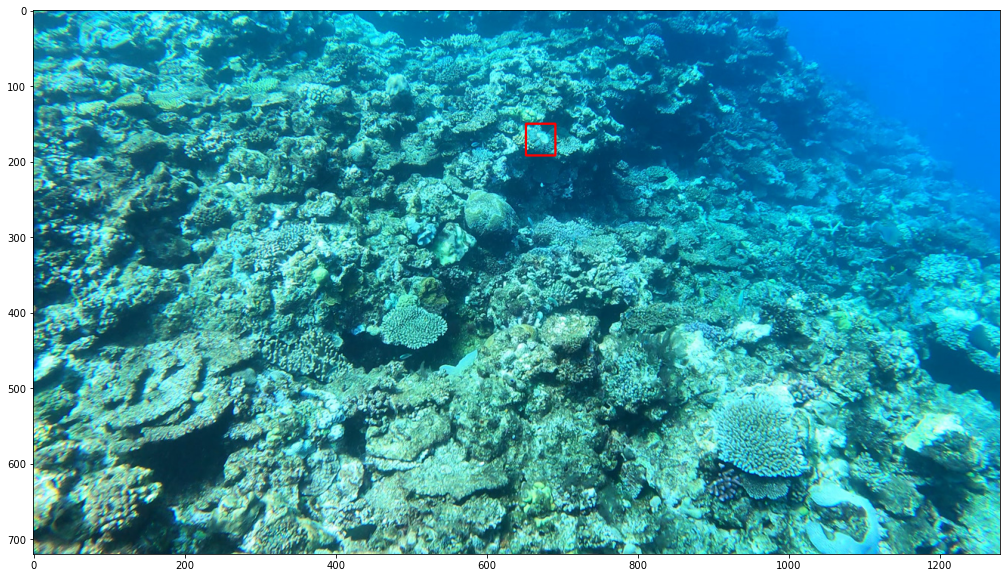

In [71]:
import onnxruntime
import torch
from torchvision.transforms import ToTensor, Normalize, Compose, Resize
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

ORIGIN_W = 1280
ORIGIN_H = 720
MODEL_W = 640
MODEL_H = 640

w_scale = ORIGIN_W / MODEL_W
h_scale = MODEL_H / MODEL_H

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

transform = Compose([
        ToTensor(),
        Resize((640, 640)),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

path = Path(config.data.common_params['data_folder'])
df = pd.read_csv(path / data_params.valid_params.params['path_to_datalist'])
df['annotation'] = df['annotation'].apply(eval)

num = 150
img_name = str(df.iloc[num]['image_path'])
annotation = df.iloc[num]['annotation']
print(annotation)
img = cv2.imread(str(path) +'/'+ img_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
shown_img = img.copy()

# Blue color in BGR
color = (255, 0, 0)
  
# # Line thickness of 2 px
thickness = 2
bboxes = []
for bbox in annotation:
    start_point = (bbox['x_min'], bbox['y_min'])
    end_point = (bbox['x_max'], bbox['y_max'])
    bboxes.append([bbox['x_min'], bbox['y_min'], bbox['x_max'], bbox['y_max']])
    shown_img = cv2.rectangle(shown_img, start_point, end_point, color, thickness)

plt.figure(figsize=(20, 10))
plt.imshow(shown_img)

In [67]:
img = transform(img)
img = torch.unsqueeze(img, 0).half().to(device)

img, bboxes

(tensor([[[[-1.5977, -1.5186, -1.9053,  ..., -2.1172, -2.1172, -2.1172],
           [-1.3232, -1.2412, -1.5713,  ..., -2.1172, -2.1172, -2.1172],
           [-0.9658, -1.1104, -1.1201,  ..., -2.1172, -2.1172, -2.1172],
           ...,
           [-0.8320, -1.3320, -0.6704,  ..., -0.9688, -0.8848, -0.8555],
           [-1.1553, -0.9800, -1.1426,  ..., -1.1885, -0.5996, -0.5977],
           [-1.2246, -1.3994, -1.7344,  ..., -1.2207, -0.4536, -0.1335]],
 
          [[ 1.3223,  1.2275,  1.1953,  ...,  0.4153,  0.4153,  0.4153],
           [ 1.3779,  1.2588,  1.1807,  ...,  0.4153,  0.4153,  0.4153],
           [ 1.2510,  0.8408,  0.8486,  ...,  0.4153,  0.4153,  0.4153],
           ...,
           [ 0.5898,  0.5620,  1.1836,  ...,  2.2344,  1.8633,  1.7178],
           [ 0.0914,  0.5044,  0.6411,  ...,  1.8115,  1.9414,  1.8223],
           [-0.1581, -0.1110, -0.0219,  ...,  1.5801,  1.7266,  2.1055]],
 
          [[ 1.3438,  1.3496,  1.7061,  ...,  2.6406,  2.6406,  2.6406],
           [ 

In [68]:
cls_score, bbox_pred, objectness = model.forward(img)
model_bboxes = model.infer_module.forward_infer(cls_score, bbox_pred, objectness)
model_bboxes

[[tensor([[325.5000, 133.7500, 345.5000, 171.2500]], device='cuda:0',
         grad_fn=<IndexBackward>),
  tensor([1], device='cuda:0')]]

((651, 133), (691, 171), [[652, 150, 691, 192]])

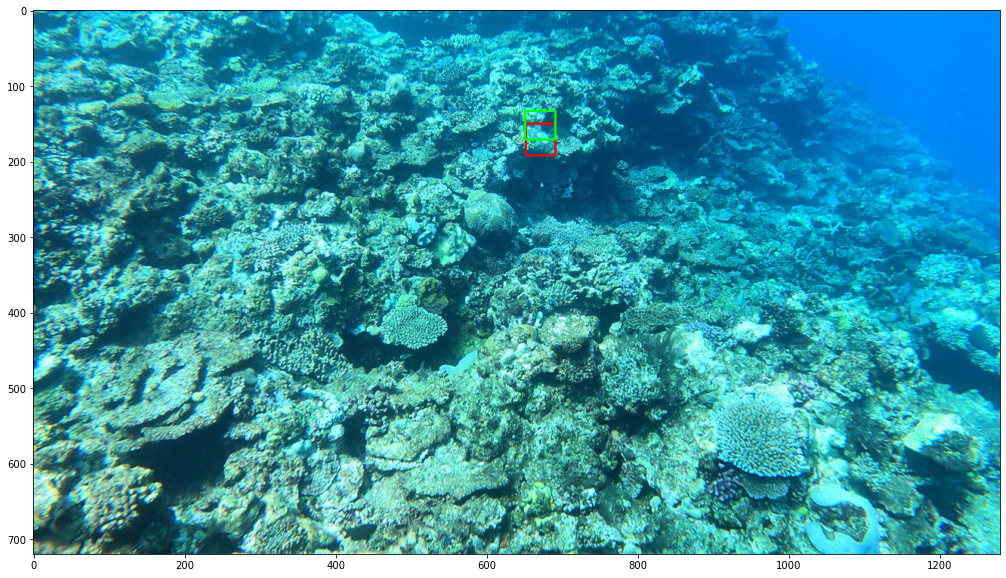

In [76]:
model_color = (0, 255, 0)
for box in model_bboxes:
    bbox = box[0][0].cpu()
    start_point = (int(w_scale * bbox[0]), int(h_scale * bbox[1]))
    end_point = (int(w_scale * bbox[2]), int(h_scale * bbox[3]))
    shown_img = cv2.rectangle(shown_img, start_point, end_point, model_color, thickness)
plt.figure(figsize=(20, 10))
plt.imshow(shown_img)
start_point, end_point, bboxes

# LOCAL INFER

In [77]:
# Copyright (c) OpenMMLab. All rights reserved.
import numpy as np
import torch
import torch.nn as nn
from torch.nn.modules.utils import _pair


class MlvlPointGenerator(nn.Module):
    """Standard points generator for multi-level (Mlvl) feature maps in 2D
    points-based detectors.

    Args:
        strides (list[int] | list[tuple[int, int]]): Strides of anchors
            in multiple feature levels in order (w, h).
        offset (float): The offset of points, the value is normalized with
            corresponding stride. Defaults to 0.5.

    Generate grid points of multiple feature levels.

        Args:
            featmap_sizes (list[tuple]): List of feature map sizes in
                multiple feature levels, each size arrange as
                as (h, w).
            dtype (:obj:`dtype`): Dtype of priors. Default: torch.float32.
            device (str): The device where the anchors will be put on.
            with_stride (bool): Whether to concatenate the stride to
                the last dimension of points.

        Return:
            list[torch.Tensor]: Points of  multiple feature levels.
            The sizes of each tensor should be (N, 2) when with stride is
            ``False``, where N = width * height, width and height
            are the sizes of the corresponding feature level,
            and the last dimension 2 represent (coord_x, coord_y),
            otherwise the shape should be (N, 4),
            and the last dimension 4 represent
            (coord_x, coord_y, stride_w, stride_h).
        
    """

    def __init__(self, strides, 
                    featmap_sizes,
                    offset=0.5,
                    dtype=torch.float16,
                    with_stride=False):
        super(MlvlPointGenerator, self).__init__()
        self.strides = [_pair(stride) for stride in strides]
        self.offset = offset
        assert self.num_levels == len(featmap_sizes)
        multi_level_priors = []
        for i in range(self.num_levels):
            priors = self.single_level_grid_priors(
                featmap_sizes[i],
                level_idx=i,
                dtype=dtype,
                with_stride=with_stride)
            multi_level_priors.append(priors)

        flatten_priors = torch.cat(multi_level_priors).float()
        self.register_buffer("flatten_priors", flatten_priors)
        

    @property
    def num_levels(self):
        """int: number of feature levels that the generator will be applied"""
        return len(self.strides)

    @property
    def num_base_priors(self):
        """list[int]: The number of priors (points) at a point
        on the feature grid"""
        return [1 for _ in range(len(self.strides))]

    def _meshgrid(self, x, y, row_major=True):
        yy, xx = torch.meshgrid(y, x)
        if row_major:
            # warning .flatten() would cause error in ONNX exporting
            # have to use reshape here
            return xx.reshape(-1), yy.reshape(-1)
        else:
            return yy.reshape(-1), xx.reshape(-1)

    def single_level_grid_priors(self,
                                 featmap_size,
                                 level_idx,
                                 dtype=torch.float16,
                                 with_stride=False):
        """Generate grid Points of a single level.

        Note:
            This function is usually called by method ``self.grid_priors``.

        Args:
            featmap_size (tuple[int]): Size of the feature maps, arrange as
                (h, w).
            level_idx (int): The index of corresponding feature map level.
            dtype (:obj:`dtype`): Dtype of priors. Default: torch.float32.
            device (str, optional): The device the tensor will be put on.
                Defaults to 'cuda'.
            with_stride (bool): Concatenate the stride to the last dimension
                of points.

        Return:
            Tensor: Points of single feature levels.
            The shape of tensor should be (N, 2) when with stride is
            ``False``, where N = width * height, width and height
            are the sizes of the corresponding feature level,
            and the last dimension 2 represent (coord_x, coord_y),
            otherwise the shape should be (N, 4),
            and the last dimension 4 represent
            (coord_x, coord_y, stride_w, stride_h).
        """
        feat_h, feat_w = featmap_size
        stride_w, stride_h = self.strides[level_idx]
        shift_x = (torch.arange(0, feat_w) + self.offset) * stride_w
        # keep featmap_size as Tensor instead of int, so that we
        # can convert to ONNX correctly
        shift_x = shift_x.to(dtype)

        shift_y = (torch.arange(0, feat_h) + self.offset) * stride_h
        # keep featmap_size as Tensor instead of int, so that we
        # can convert to ONNX correctly
        shift_y = shift_y.to(dtype)
        shift_xx, shift_yy = self._meshgrid(shift_x, shift_y)
        if not with_stride:
            shifts = torch.stack([shift_xx, shift_yy], dim=-1)
        else:
            # use `shape[0]` instead of `len(shift_xx)` for ONNX export
            stride_w = shift_xx.new_full((shift_xx.shape[0], ),
                                         stride_w).to(dtype)
            stride_h = shift_xx.new_full((shift_yy.shape[0], ),
                                         stride_h).to(dtype)
            shifts = torch.stack([shift_xx, shift_yy, stride_w, stride_h],
                                 dim=-1)
        all_points = shifts
        return all_points

    def valid_flags(self, featmap_sizes, pad_shape):
        """Generate valid flags of points of multiple feature levels.

        Args:
            featmap_sizes (list(tuple)): List of feature map sizes in
                multiple feature levels, each size arrange as
                as (h, w).
            pad_shape (tuple(int)): The padded shape of the image,
                 arrange as (h, w).
            device (str): The device where the anchors will be put on.

        Return:
            list(torch.Tensor): Valid flags of points of multiple levels.
        """
        assert self.num_levels == len(featmap_sizes)
        multi_level_flags = []
        for i in range(self.num_levels):
            point_stride = self.strides[i]
            feat_h, feat_w = featmap_sizes[i]
            h, w = pad_shape[:2]
            valid_feat_h = min(int(np.ceil(h / point_stride[1])), feat_h)
            valid_feat_w = min(int(np.ceil(w / point_stride[0])), feat_w)
            flags = self.single_level_valid_flags((feat_h, feat_w),
                                                  (valid_feat_h, valid_feat_w))
            multi_level_flags.append(flags)
        return multi_level_flags

    def single_level_valid_flags(self,
                                 featmap_size,
                                 valid_size):
        """Generate the valid flags of points of a single feature map.

        Args:
            featmap_size (tuple[int]): The size of feature maps, arrange as
                as (h, w).
            valid_size (tuple[int]): The valid size of the feature maps.
                The size arrange as as (h, w).
            device (str, optional): The device where the flags will be put on.
                Defaults to 'cuda'.

        Returns:
            torch.Tensor: The valid flags of each points in a single level \
                feature map.
        """
        feat_h, feat_w = featmap_size
        valid_h, valid_w = valid_size
        assert valid_h <= feat_h and valid_w <= feat_w
        valid_x = torch.zeros(feat_w, dtype=torch.bool)
        valid_y = torch.zeros(feat_h, dtype=torch.bool)
        valid_x[:valid_w] = 1
        valid_y[:valid_h] = 1
        valid_xx, valid_yy = self._meshgrid(valid_x, valid_y)
        valid = valid_xx & valid_yy
        return valid

    def sparse_priors(self,
                      prior_idxs,
                      featmap_size,
                      level_idx,
                      dtype=torch.float16,
                      ):
        """Generate sparse points according to the ``prior_idxs``.

        Args:
            prior_idxs (Tensor): The index of corresponding anchors
                in the feature map.
            featmap_size (tuple[int]): feature map size arrange as (w, h).
            level_idx (int): The level index of corresponding feature
                map.
            dtype (obj:`torch.dtype`): Date type of points. Defaults to
                ``torch.float32``.
            device (obj:`torch.device`): The device where the points is
                located.
        Returns:
            Tensor: Anchor with shape (N, 2), N should be equal to
            the length of ``prior_idxs``. And last dimension
            2 represent (coord_x, coord_y).
        """
        height, width = featmap_size
        x = (prior_idxs % width + self.offset) * self.strides[level_idx][0]
        y = ((prior_idxs // width) % height +
             self.offset) * self.strides[level_idx][1]
        prioris = torch.stack([x, y], 1).to(dtype)
        return prioris

strides=[8, 16, 32]
featmap_sizes = [torch.Size([int(MODEL_H/stride), int(MODEL_W/stride)]) for stride in strides]
prior_generator = MlvlPointGenerator(strides, featmap_sizes, offset=0, with_stride=True)
flatten_priors = prior_generator.flatten_priors
flatten_priors

tensor([[  0.,   0.,   8.,   8.],
        [  8.,   0.,   8.,   8.],
        [ 16.,   0.,   8.,   8.],
        ...,
        [544., 608.,  32.,  32.],
        [576., 608.,  32.,  32.],
        [608., 608.,  32.,  32.]])

In [108]:
from torchvision.ops import batched_nms

def _bbox_decode(priors, bbox_preds):
        xys = (bbox_preds[..., :2] * priors[:, 2:]) + priors[:, :2]
        whs = bbox_preds[..., 2:].exp() * priors[:, 2:]

        tl_x = (xys[..., 0] - whs[..., 0] / 2)
        tl_y = (xys[..., 1] - whs[..., 1] / 2)
        br_x = (xys[..., 0] + whs[..., 0] / 2)
        br_y = (xys[..., 1] + whs[..., 1] / 2)

        decoded_bboxes = torch.stack([tl_x, tl_y, br_x, br_y], -1)

        return decoded_bboxes

def _bboxes_nms(cls_scores, bboxes, score_factor, confidance_th = 0.25, iou_threshold = 0.65):
    
    cls_scores = torch.cat([1 - cls_scores, cls_scores], -1)
    max_scores, labels = torch.max(cls_scores, 1)
    valid_mask = score_factor * max_scores >= confidance_th

    bboxes = bboxes[valid_mask].float()
    scores = max_scores[valid_mask] * score_factor[valid_mask]
    labels = labels[valid_mask]

    if labels.numel() == 0:
        return bboxes, labels
    else:
        indexes = batched_nms(bboxes.double(), scores.double(), labels, iou_threshold=iou_threshold)
        return bboxes[indexes], labels[indexes]

def _get_flatten_output(
                        cls_scores,
                        bbox_preds,
                        objectnesses,
                        num_classes=1
                        ):

    num_imgs = bbox_preds[0].shape[0]
    
    flatten_cls_preds = [
        cls_pred.permute(0, 2, 3, 1).reshape(num_imgs, -1,
                                                num_classes)
        for cls_pred in cls_scores
    ]
    flatten_bbox_preds = [
        bbox_pred.permute(0, 2, 3, 1).reshape(num_imgs, -1, 4)
        for bbox_pred in bbox_preds
    ]
    flatten_objectness = [
        objectness.permute(0, 2, 3, 1).reshape(num_imgs, -1)
        for objectness in objectnesses
    ]

    flatten_cls_preds = torch.cat(flatten_cls_preds, dim=1).double().detach().cpu()
    flatten_bbox_preds = torch.cat(flatten_bbox_preds, dim=1).double().detach().cpu()
    flatten_objectness = torch.cat(flatten_objectness, dim=1).double().detach().cpu()
    flatten_bboxes = _bbox_decode(flatten_priors, flatten_bbox_preds).double().detach().cpu()

    return flatten_cls_preds, flatten_objectness, flatten_bboxes, flatten_bbox_preds


flatten_cls_preds, flatten_objectness, flatten_bboxes, flatten_bbox_preds = _get_flatten_output(
                                                                                            cls_scores=cls_score,
                                                                                            bbox_preds=bbox_pred,
                                                                                            objectnesses=objectness
                                                                                            )

result_list = []
flatten_cls_preds = flatten_cls_preds.sigmoid()
flatten_objectness = flatten_objectness.sigmoid()

for img_id in range(len(flatten_cls_preds)):
    _cls_scores = flatten_cls_preds[img_id].double().detach().cpu()
    _score_factor = flatten_objectness[img_id]
    _bboxes = flatten_bboxes[img_id]
    
    result_list.append(_bboxes_nms(cls_scores=_cls_scores, bboxes=_bboxes, score_factor=_score_factor))

#change tuple to list        
result_list = [list(elem) for elem in result_list]

result_list

[[tensor([[325.5452, 133.7679, 345.3454, 171.2321]]), tensor([1])]]

In [110]:
traced = torch.jit.trace(model.forward, torch.rand(1, 3, 640, 640, device=device).half())

/home/lolik/miniconda3/envs/torchok/lib/python3.7/site-packages/torch/jit/_trace.py:959: TracerWarning: Encountering a list at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tuple` instead. for `dict`, use a `NamedTuple` instead). If you absolutely need this and know the side effects, pass strict=False to trace() to allow this behavior.
  argument_names,


In [111]:
traced.save('../yolox.pt')